In [1]:
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import numpy as np
import anndata
import scvi
import os
sc.set_figure_params(figsize=(4, 4))


num_of_clusters = 8

ToolName = 'scvi' 
DatasetName = 'kumar-8-hard'
Data_path = '../dataset/{}-filtered/10X/'.format(DatasetName)
save_path = '../results/{}/{}/'.format(DatasetName, ToolName)


if not os.path.exists(save_path):
    os.makedirs(save_path)

# for white background of figures (only for docs rendering)
# %config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
# %config InlineBackend.figure_format='retina'

Global seed set to 0


## Loading and preparing data

In [2]:
adata = sc.read_10x_mtx(
    Data_path,  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=False
)
adata

AnnData object with n_obs × n_vars = 499 × 42538
    var: 'gene_ids'

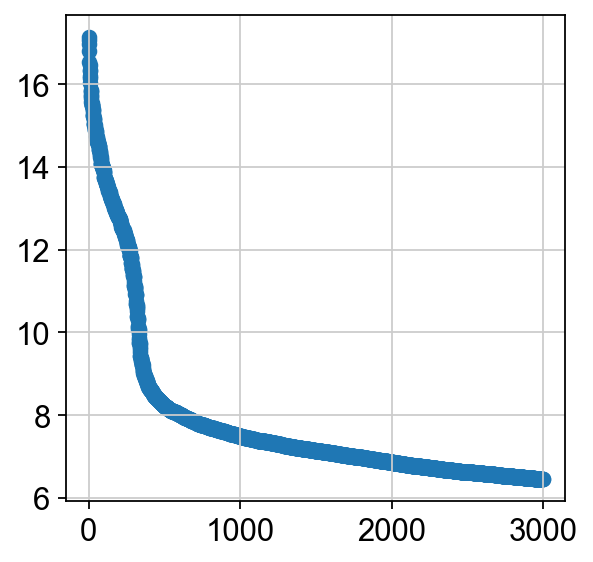

In [3]:
# adata.layers["counts"] = adata.X.copy()  # preserve counts
matrix = adata.X
# from sparse matrix to dense matrix
matrix = matrix.todense()
# find the most variable features (columns) of the matrix sorted by variance
variances = np.sort(-np.var(matrix, axis=0))
sorted_array = [np.log(-i) for i in variances.T][:3000]
# plot the variance of the features
plt.scatter([i for i in range(len(sorted_array))], sorted_array)

In [4]:
adata.layers["counts"] = adata.X.copy()  # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

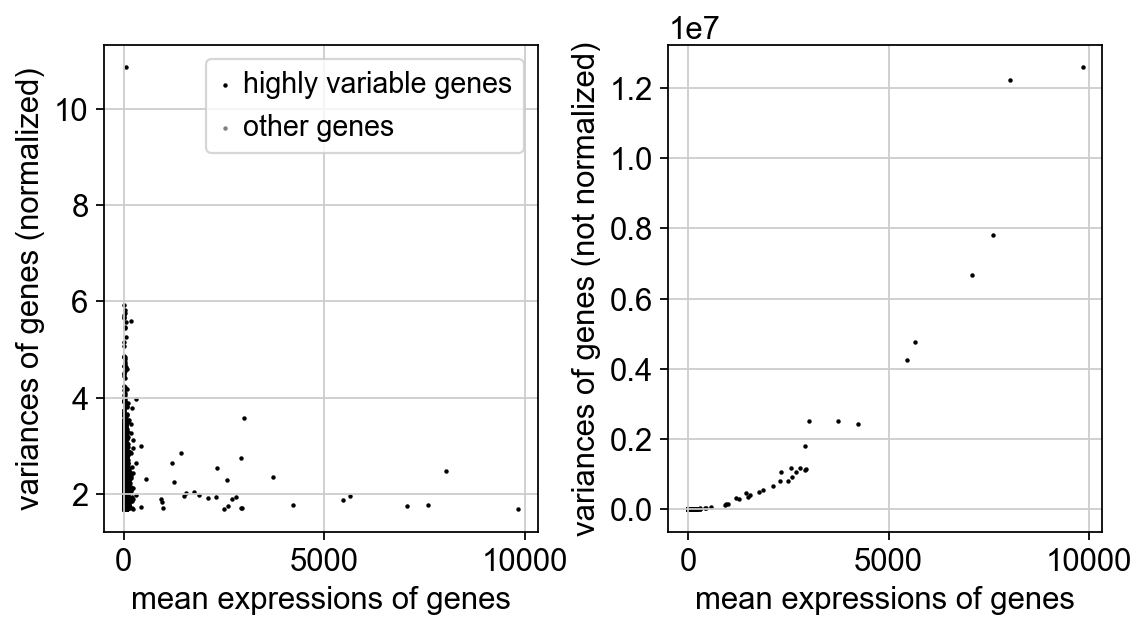

In [5]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=3000,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
)
sc.pl.highly_variable_genes(adata)

In [6]:
sc.pp.scale(adata, max_value=10)

In [7]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
)

## Creating and training a model

While we highlight the scVI model here, the API is consistent across all scvi-tools models and is inspired by that of [scikit-learn](https://scikit-learn.org/stable/). For a full list of options, see the scvi [documentation](https://scvi-tools.org).

In [8]:
if os.path.exists('./models/{}/'.format(DatasetName)):
    model = scvi.model.SCVI.load('./models/{}/'.format(DatasetName), adata=adata, use_gpu=True)
else:
    model = scvi.model.SCVI(adata)
    model.train(use_gpu=False)
    model.save('./models/{}/'.format(DatasetName))
    
model

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/paulmagos/miniconda3/envs/CHLPy/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Users/paulmagos/miniconda3/envs/CHLPy/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [00:42<00:00,  9.47it/s, loss=8.57e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:42<00:00,  9.44it/s, loss=8.57e+03, v_num=1]


SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Trained
Model's adata is minified?: False

We can see an overview of the model by printing it.

## Obtaining model outputs

In [9]:
latent = model.get_latent_representation()

It's often useful to store the outputs of scvi-tools back into the original anndata, as it permits interoperability with Scanpy.

In [10]:
adata.obsm["X_scVI"] = latent
adata_subset = adata

The `model.get...()` functions default to using the anndata that was used to initialize the model. It's possible to also query a subset of the anndata, or even use a completely independent anndata object as long as the anndata is organized in an equivalent fashion.

In [11]:
latent_subset = model.get_latent_representation(adata_subset)

In [12]:
denoised = model.get_normalized_expression(adata_subset)
denoised.iloc[:5, :5]

,Gene1,Gene37,Gene39,Gene55,Gene66
Cell1,0.000713,0.000340,0.000312,0.000012,0.000199
Cell2,0.000933,0.000368,0.000347,0.000033,0.000310
Cell3,0.000836,0.000342,0.000280,0.000020,0.000155
Cell4,0.000751,0.000349,0.000399,0.000063,0.000228
Cell5,0.000726,0.000481,0.000201,0.000021,0.000229


Let's store the normalized values back in the anndata.

In [13]:
adata.layers["scvi_normalized"] = model.get_normalized_expression()

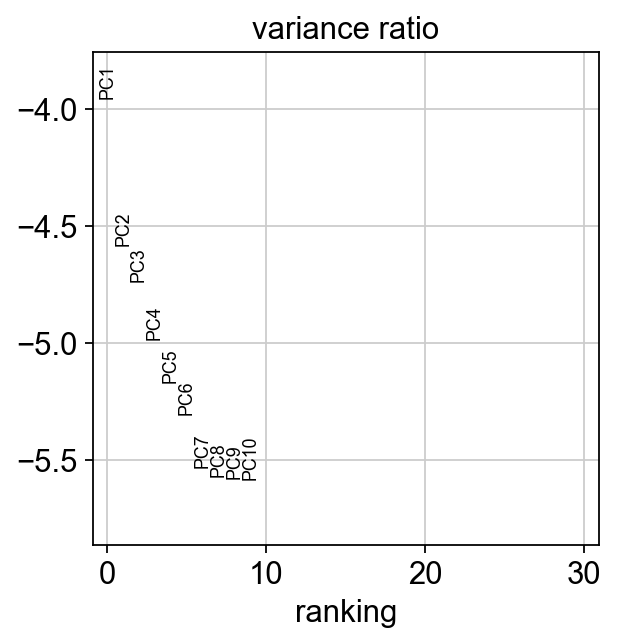

In [14]:
# run PCA then generate UMAP plots
sc.tl.pca(adata, svd_solver="arpack", n_comps=10, use_highly_variable=True)
sc.pl.pca_variance_ratio(adata, log=True)

In [15]:
sc.pp.neighbors(adata, n_pcs=10, n_neighbors=20)

/Users/paulmagos/miniconda3/envs/CHLPy/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/paulmagos/miniconda3/envs/CHLPy/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/paulmagos/miniconda3/envs/CHLPy/lib/python3.10/site-pac

In [16]:
# neighbors were already computed using scVI

res = 0.001
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=res)
while not (adata.obs.leiden_scVI.values.categories.values).shape == (num_of_clusters,) or res == 1.0:
    res += 0.005
    sc.tl.leiden(adata, key_added="leiden_scVI", resolution=res)
print(adata)

AnnData object with n_obs × n_vars = 499 × 3000
    obs: '_scvi_batch', '_scvi_labels', 'leiden_scVI'
    var: 'gene_ids', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'pca', 'neighbors', 'leiden'
    obsm: 'X_scVI', 'X_pca'
    varm: 'PCs'
    layers: 'counts', 'scvi_normalized'
    obsp: 'distances', 'connectivities'


/Users/paulmagos/miniconda3/envs/CHLPy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


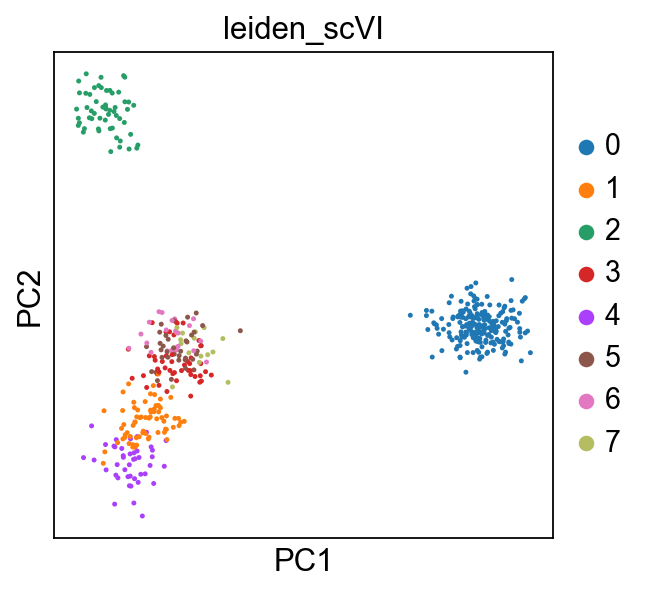

In [17]:
sc.pl.pca(
    adata,
    color=["leiden_scVI"],
    size=20,
)

In [18]:
sc.tl.rank_genes_groups(adata, 'leiden_scVI', method='wilcoxon') # method='wilcoxon' method='logreg'

In [ ]:
number_of_genes = 50

names = adata.uns['rank_genes_groups']['names'][:number_of_genes]
# transform each element of names in a list
names = [list(x) for x in names]

df = pd.DataFrame(columns=['gene', 'cluster', 'rank'])

for i in range(num_of_clusters):
    to_add = [ [names[j][i], i, j] for j in range(number_of_genes)]
    to_add = pd.DataFrame(to_add, columns=['gene', 'cluster', 'rank'])
    df = pd.concat([df, to_add],  ignore_index=True)


df['cluster'] += 1
df['rank'] += 1

df.to_csv(save_path+'markers.csv', index=False)

In [ ]:

df = pd.DataFrame(adata.obs['leiden_scVI'])

labels = df.rename(columns={'leiden_scVI': 'cluster'})
# rename index as cell
labels.index.names = ['cell']

labels['cluster'] = labels['cluster'].astype(int) + 1


labels.to_csv(save_path+'clustering_labels.csv')